<a href="https://colab.research.google.com/github/Katinon/Self-Study/blob/main/%ED%98%BC%EC%9E%90-%EA%B3%B5%EB%B6%80%ED%95%98%EB%8A%94-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%94%A5%EB%9F%AC%EB%8B%9D/20_RecurrentNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 준비하기
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape, test_input.shape)

print(len(train_input[0]))

print(len(train_input[1]))

(25000,) (25000,)
218
189


In [2]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [3]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [4]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)


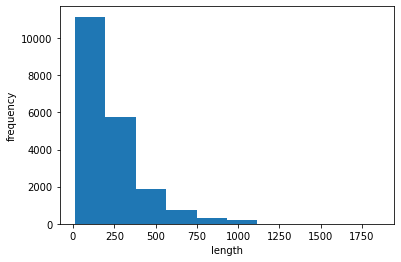

In [5]:
import numpy as np
import matplotlib.pyplot as plt
lengths = np.array([len(x) for x in train_input])

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')

plt.show()

In [6]:
#대부분 리뷰는 짧기 때문에 100개의 단어만 사용
# 100개보다 짧거나 긴 리뷰를 위해 패딩 사용
# 짧은 리뷰는 앞에서부터 0 토큰을 채우고, 긴 리뷰는 잘라냄

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

print(train_seq.shape)
# 20000개의 리뷰, 100개의 토큰 길이

(20000, 100)


In [7]:
# 순환층 클래스, SimpleRNN
# 이진 분류이므로 마지막 출력층 활성화 함수 시그모이드

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid')) #이진 분류

In [8]:
# 토큰을 정수로 변환한 이 데이터를 신경망에 주입하면
# 큰 정수가 큰 활성화 함수를 만들기 때문에
# 크기 속성을 없애고 각 정수를 고유하게 표현 => 원 핫 인코딩
# 해당 원소만 1이고 나머지는 0

train_oh = keras.utils.to_categorical(train_seq)
print(train_oh.shape)
# 2만개의 샘플, 100개의 토큰 길이, 0~499의 토큰범위

(20000, 100, 500)


In [9]:
print(train_oh[0][0][:12])
print(np.sum(train_oh[0][0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0


In [10]:
val_oh = keras.utils.to_categorical(val_seq)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 순환 신경망 훈련하기
# RMSprop 학습률 0.0001로 만들기 위해 객체 따로 지정

rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data = (val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 14s 41ms/step - loss: 0.6968 - accuracy: 0.5038 - val_loss: 0.6970 - val_accuracy: 0.5008
Epoch 2/100
313/313 [==============================] - 12s 40ms/step - loss: 0.6898 - accuracy: 0.5366 - val_loss: 0.6878 - val_accuracy: 0.5494
Epoch 3/100
313/313 [==============================] - 12s 40ms/step - loss: 0.6800 - accuracy: 0.5793 - val_loss: 0.6774 - val_accuracy: 0.5900
Epoch 4/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6692 - accuracy: 0.6147 - val_loss: 0.6663 - val_accuracy: 0.6260
Epoch 5/100
313/313 [==============================] - 13s 40ms/step - loss: 0.6562 - accuracy: 0.6446 - val_loss: 0.6534 - val_accuracy: 0.6448
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6415 - accuracy: 0.6657 - val_loss: 0.6383 - val_accuracy: 0.6702
Epoch 7/100
313/313 [==============================] - 12s 38ms/step - loss: 0.6251 - accuracy: 0.6866 - val_loss: 0.6247 - val_ac

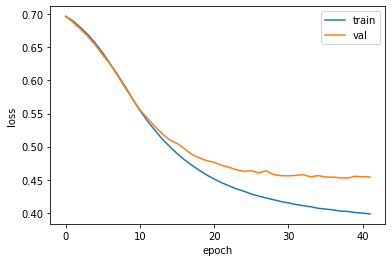

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [26]:
# 원핫 인코딩의 단점은 입력 데이터가 매우 커진다는 것
# 각 단어를 고정된 크기의 실수 벡터로 바꿈

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [27]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data = (val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 22ms/step - loss: 0.6948 - accuracy: 0.5082 - val_loss: 0.6935 - val_accuracy: 0.5080
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6908 - accuracy: 0.5289 - val_loss: 0.6921 - val_accuracy: 0.5202
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6876 - accuracy: 0.5490 - val_loss: 0.6913 - val_accuracy: 0.5234
Epoch 4/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6845 - accuracy: 0.5628 - val_loss: 0.6910 - val_accuracy: 0.5254
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6813 - accuracy: 0.5723 - val_loss: 0.6910 - val_accuracy: 0.5250
Epoch 6/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6780 - accuracy: 0.5811 - val_loss: 0.6912 - val_accuracy: 0.5250
Epoch 7/100
313/313 [==============================] - 7s 22ms/step - loss: 0.6747 - accuracy: 0.5874 - val_loss: 0.6918 - val_accuracy:

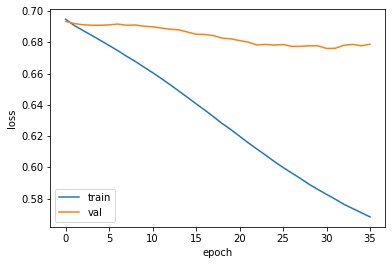

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()